In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpecFromSubplotSpec
import cartopy.crs as ccrs

from hlpr_func import lat_mean, make_cyclic

In [7]:
terra = xr.open_dataset("MODIS_AOD/Terra_combined.nc").sortby("lat")
terra["lon"] = (terra.coords['lon'] + 360) % 360
terra = make_cyclic(terra.sortby("lon"))
terra = terra.rename_vars({"aod":"aod_terra", "sza":"sza_terra"})

aqua = xr.open_dataset("MODIS_AOD/Aqua_combined.nc").sortby("lat")
aqua["lon"] = (aqua.coords['lon'] + 360) % 360
aqua = make_cyclic(aqua.sortby("lon"))
aqua = aqua.rename_vars({"aod":"aod_aqua", "sza":"sza_aqua"})
ds = xr.merge([terra[["aod_terra"]], aqua[["aod_aqua"]]])
terra.close()
aqua.close()

era = xr.open_dataset("ERA5-CAMS/era5-interpolated.nc")
era = era[["landmask"]]
ds = xr.merge([ds, era])
era.close()

ds["aod_mean"] = (ds.aod_terra + ds.aod_aqua)/2
ds

<xarray.Dataset> Size: 379MB
Dimensions:    (lon: 361, lat: 180, time: 292)
Coordinates:
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
  * lat        (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2kB 2000-02-15 2000-03-15 ... 2024-05-15
Data variables:
    aod_terra  (lat, lon, time) float32 76MB nan nan nan nan ... nan nan nan nan
    aod_aqua   (lat, lon, time) float32 76MB nan nan nan nan ... nan nan nan nan
    landmask   (time, lat, lon) float64 152MB nan nan nan nan ... nan nan nan
    aod_mean   (lat, lon, time) float32 76MB nan nan nan nan ... nan nan nan nan

In [8]:
# add weights
weights = ds.time.dt.days_in_month
weights = weights.where(weights.time.dt.month!=2, 28.65)
ds["days_in_month"] = weights

climatology = ds.groupby("time.month").mean("time")
deseasonalized = ds.groupby("time.month") - climatology + climatology.weighted(climatology.days_in_month).mean("month")
so = lat_mean(deseasonalized.sel(lat=slice(-75,-45)).where(deseasonalized.landmask==0).mean("lon"))

da = deseasonalized
da = da.assign_coords({"month_since_start": ("time", np.arange(len(da.time.values)))})
da = da.swap_dims({"time":"month_since_start"})
fit = da.polyfit("month_since_start", 1, w=da.days_in_month)
da.close()

fit

/glade/u/home/csinger/anaconda3/envs/albedo/lib/python3.12/site-packages/xarray/core/nputils.py:256: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/csinger/anaconda3/envs/albedo/lib/python3.12/site-packages/xarray/core/nputils.py:256: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/csinger/anaconda3/envs/albedo/lib/python3.12/site-packages/xarray/core/nputils.py:256: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


<xarray.Dataset> Size: 4MB
Dimensions:                             (degree: 2, lat: 180, lon: 361)
Coordinates:
  * degree                              (degree) int64 16B 1 0
  * lat                                 (lat) float32 720B -89.5 -88.5 ... 89.5
  * lon                                 (lon) float32 1kB 0.5 1.5 ... 360.5
Data variables:
    aod_terra_polyfit_coefficients      (degree, lat, lon) float64 1MB nan .....
    aod_aqua_polyfit_coefficients       (degree, lat, lon) float64 1MB nan .....
    landmask_polyfit_coefficients       (degree, lat, lon) float64 1MB 1.311e...
    aod_mean_polyfit_coefficients       (degree, lat, lon) float64 1MB nan .....
    days_in_month_polyfit_coefficients  (degree) float64 16B -8.306e-17 30.49

In [9]:
ar = xr.open_dataset("AERONET/Monthly_SO_AOD_500nm_clean.nc")

# add weights
weights = ar.time.dt.days_in_month
weights = weights.where(weights.time.dt.month!=2, 28.65)
ar["days_in_month"] = weights

arclimatology = ar.groupby("time.month").mean("time")
ardeseasonalized = ar.groupby("time.month") - arclimatology + arclimatology.weighted(arclimatology.days_in_month).mean("month")

da = ardeseasonalized
da = da.assign_coords({"month_since_start": ("time", np.arange(len(da.time.values)))})
da = da.swap_dims({"time":"month_since_start"})
arfit = da.polyfit("month_since_start", 1 , w=da.days_in_month)
arfit = arfit.drop_vars(["NUM_POINTS_AOD_500nm_polyfit_coefficients","lat_polyfit_coefficients","lon_polyfit_coefficients"])
da.close()

arfit

<xarray.Dataset> Size: 872B
Dimensions:                             (degree: 2, location: 10)
Coordinates:
  * degree                              (degree) int64 16B 1 0
  * location                            (location) <U17 680B 'Crozet_Island' ...
Data variables:
    AOD_500nm_polyfit_coefficients      (degree, location) float64 160B -3.17...
    days_in_month_polyfit_coefficients  (degree) float64 16B 1.311e-17 30.49

In [10]:
# fig,axes = plt.subplots(1, 2, figsize=(7,4), subplot_kw={"projection":ccrs.Orthographic(180, -90)})

# ax = axes[0]
# cr = 0.2 # 1
# clim = time_mean(ds)
# var = "aod_mean"
# cf = ax.contourf(clim.lon, clim.lat, clim[var], np.linspace(0, cr, 20), cmap="viridis", extend="both", transform=ccrs.PlateCarree())

# da = time_mean(ar)
# pc = ax.scatter(da.lon, da.lat, s=50, c=da.AOD_500nm, cmap="viridis", edgecolors="k",
#                 vmin=0, vmax=cr, zorder=1, transform=ccrs.PlateCarree())
# ax.set_title("AOD climatology")
# ax.coastlines()
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', linestyle=':')
# plt.colorbar(cf, orientation='horizontal', shrink=0.8, ticks = np.linspace(0, cr, 3))

# ax = axes[1]
# cr = 0.1
# trend = fit.sel(degree=1)[var+"_polyfit_coefficients"] * 120 # convert from per month to per decade

# cf = ax.contourf(fit.lon, fit.lat, trend, np.linspace(-cr, cr, 20), cmap="bwr", extend="both", transform=ccrs.PlateCarree())
# trend = arfit.sel(degree=1)["AOD_500nm_polyfit_coefficients"] * 120 # convert from per month to per decade
# pc = ax.scatter(da.lon, da.lat, s=50, c=trend, cmap="bwr", edgecolors="k", 
#                 vmin=-cr, vmax=cr, zorder=1, transform=ccrs.PlateCarree())
# ax.set_title("AOD trend [decade$^{-1}$]")
# ax.coastlines()
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', linestyle=':')
# plt.colorbar(cf, orientation='horizontal', shrink=0.8, ticks = np.linspace(-cr, cr, 3))

# # plt.savefig("paper-figures/modis_aeronet_clim_trend.png", dpi=200, facecolor="w", bbox_inches="tight")
# plt.show()

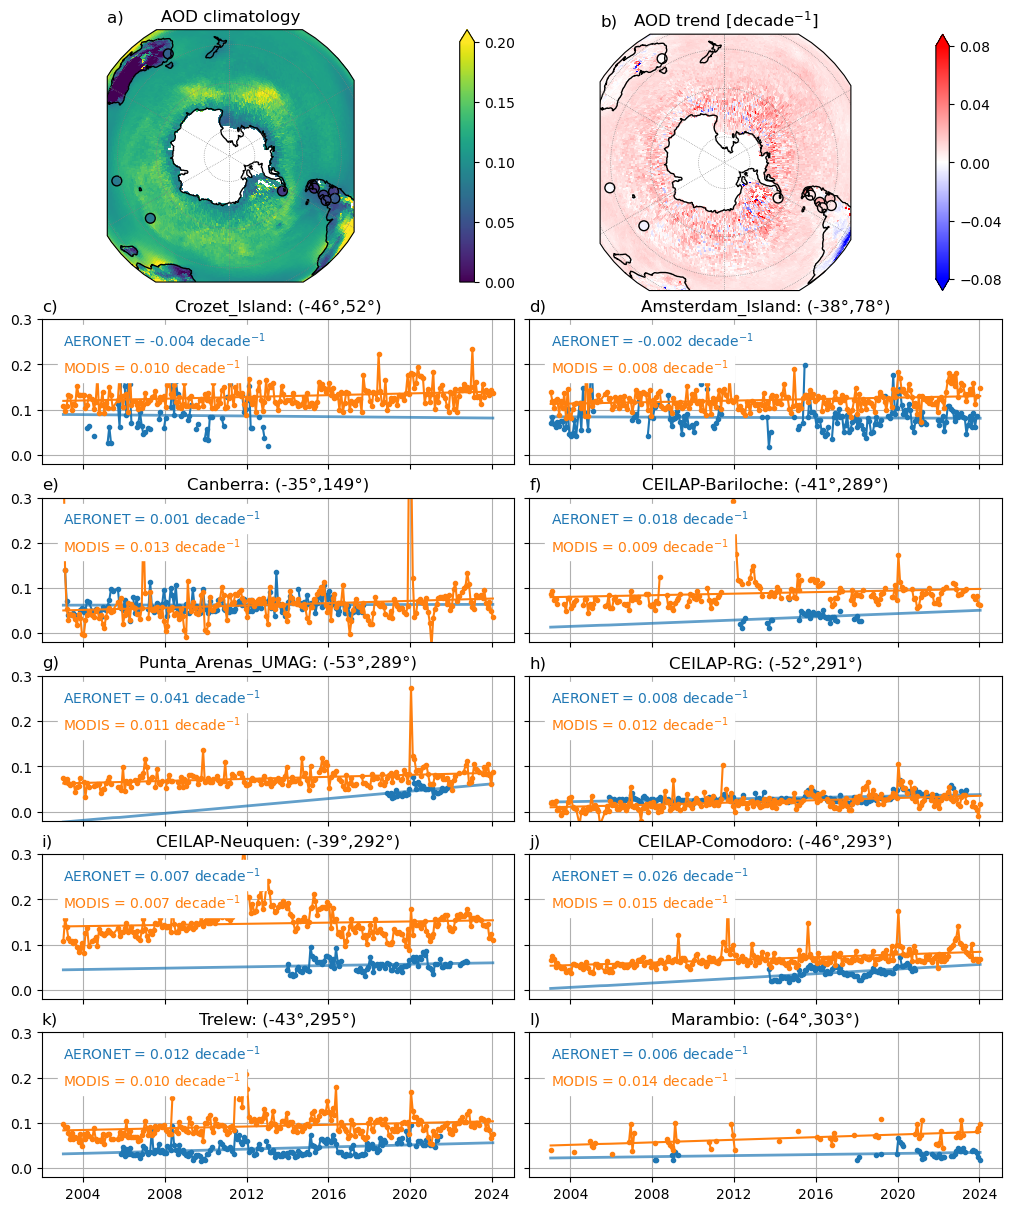

In [14]:
fig = plt.figure(figsize=(10,12), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=6, height_ratios=[2,1,1,1,1,1])
map_cb_gs_left = GridSpecFromSubplotSpec(1, 2, width_ratios=[30, 1], subplot_spec=gs[0, 0], wspace=0)
map_cb_gs_right = GridSpecFromSubplotSpec(1, 2, width_ratios=[30, 1], subplot_spec=gs[0, 1], wspace=0)

ax = fig.add_subplot(map_cb_gs_left[0, 0], projection=ccrs.Orthographic(180, -90))
ax.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())
ax.set_anchor("C")

clim = ds.weighted(ds.days_in_month).mean("time")
var = "aod_mean"
cr = 0.2
cf = ax.pcolormesh(clim.lon, clim.lat, clim[var], vmin=0, vmax=cr, cmap="viridis", transform=ccrs.PlateCarree())

da = ar.weighted(ar.days_in_month).mean("time")
pc = ax.scatter(da.lon, da.lat, s=50, c=da.AOD_500nm, cmap="viridis", edgecolors="k",
                vmin=0, vmax=cr, zorder=1, transform=ccrs.PlateCarree())
ax.set_title("AOD climatology")
ax.set_title("a)", loc="left")
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', linestyle=':')

cax = fig.add_subplot(map_cb_gs_left[0, 1])
fig.colorbar(cf, cax=cax, extend="max", orientation='vertical', ticks=np.linspace(0, cr, 5))

####

ax = fig.add_subplot(map_cb_gs_right[0, 0], projection=ccrs.Orthographic(180, -90))
ax.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())
ax.set_anchor("C")

trend = fit.sel(degree=1)[var+"_polyfit_coefficients"] * 120 # convert from per month to per decade
cr = 0.08

cf = ax.pcolormesh(fit.lon, fit.lat, trend, vmin=-cr, vmax=cr, cmap="bwr", transform=ccrs.PlateCarree())
trend = arfit.sel(degree=1)["AOD_500nm_polyfit_coefficients"] * 120 # convert from per month to per decade
pc = ax.scatter(da.lon, da.lat, s=50, c=trend, cmap="bwr", edgecolors="k", 
                vmin=-cr, vmax=cr, zorder=1, transform=ccrs.PlateCarree())
ax.set_title("AOD trend [decade$^{-1}$]")
ax.set_title("b)", loc="left")
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', linestyle=':')

cax = fig.add_subplot(map_cb_gs_right[0, 1])
fig.colorbar(cf, cax=cax, extend="both", orientation='vertical', ticks=np.linspace(-cr, cr, 5))

####

letter = ["c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)", "k)", "l)", "m)"]
for i, loc in enumerate(ardeseasonalized.location.values):
    ai = ardeseasonalized.sel(location=loc)
    mi = deseasonalized.sel(time=ai.time).interp(lat=ai.lat, lon=ai.lon, method="linear")

    col = i % 2
    row = i // 2 + 1
    ax = fig.add_subplot(gs[row,col])
    ax.set_title("{}: ({:.0f}°,{:.0f}°)".format(loc, ai.lat.mean(), ai.lon.mean()))
    ax.set_title(letter[i], loc="left")
    
    ax.plot(ai.time, ai.AOD_500nm, '.-')
    ai = ai.assign_coords({"month_since_start": ("time", np.arange(len(ai.time.values)))}).swap_dims({"time":"month_since_start"})
    aifit = ai.polyfit("month_since_start", 1, w=ai.days_in_month).AOD_500nm_polyfit_coefficients
    ax.plot(ai.time, aifit.sel(degree=0) + aifit.sel(degree=1)*ai.month_since_start, color="C0", lw=2, alpha=0.7)
    ax.text(ai.time.values[0], 0.24, "AERONET = {:.3f}".format(aifit.sel(degree=1) * 120)+" decade$^{-1}$", color="C0", backgroundcolor="w")
    
    ax.plot(mi.time, mi.aod_mean, '.-')
    mi = mi.assign_coords({"month_since_start": ("time", np.arange(len(mi.time.values)))}).swap_dims({"time":"month_since_start"})
    mifit = mi.polyfit("month_since_start", 1, w=mi.days_in_month).aod_mean_polyfit_coefficients
    ax.plot(mi.time, mifit.sel(degree=0) + mifit.sel(degree=1)*mi.month_since_start, color="C1")
    ax.text(mi.time.values[0], 0.18, "MODIS = {:.3f}".format(mifit.sel(degree=1) * 120)+" decade$^{-1}$", color="C1", backgroundcolor="w")
    
    ax.grid()
    ax.set_ylim(-0.02,0.3)
    if row < 5:
        ax.set_xticklabels([])
    if col == 1:
        ax.set_yticklabels([])

plt.savefig("paper-figures/aeronet_modis.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()